## Libraries

In [25]:
from optbinning import OptimalBinning
from loan_data.preprocess_functions import preprocess
from init_char_analysis import *
import numpy as np
import glob
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn import linear_model, metrics
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score    
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

## Read in csv's

In [4]:
path = "../../dataset/"
files = glob.glob(path + "/*.csv") 
processed_df = []
for file in files:
    if file == "../../dataset/2019_stat.csv":
        continue 
    print(file)
    temp_data = pd.read_csv(file)
    processed_df.append(temp_data)
    del temp_data
processed_df = pd.concat(processed_df)

../../dataset/2023_stat.csv
../../dataset/2022_stat.csv
../../dataset/2020_stat.csv
../../dataset/2021_stat.csv


In [5]:
processed_df.columns

Index(['LOAN_ID', 'ORIG_RATE', 'ORIG_AMOUNT', 'ORIG_TERM', 'OLTV', 'NUM_BO',
       'DTI', 'CSCORE_B', 'CSCORE_C', 'FTHB_FLAG', 'PUR_Cash_out',
       'PUR_Refinance', 'PUR_Purchase', 'PRO_Condominium', 'PRO_Co_operative',
       'PRO_Planned_Urban', 'PRO_Manufact_Home', 'PRO_Single_Family',
       'NUM_UNIT', 'OCC_Principal', 'OCC_Second', 'OCC_Investor', 'STATE',
       'ZIP', 'MSA', 'MI_PCT', 'MI_Borrower', 'MI_Lender', 'MI_Investor',
       'AQSN_DTE', 'ORIG_DTE', 'FRST_DTE', 'LAST_RATE', 'LAST_UPB',
       'LAST_ACTIVITY_DATE', 'DLQ_30_FLAG', 'DLQ_60_FLAG', 'DLQ_90_FLAG',
       'DLQ_120_FLAG', 'Ongoing', 'Current_DLQ', 'Prepaid_Matured',
       'Third_Party_Sale', 'Short_Sale', 'Repurchased', 'Deed_In_Lieu',
       'Non_Performing_NS', 'Reperforming_NS', 'COMPLETE_FLAG', 'NET_LOSS',
       'NET_SEV'],
      dtype='object')

# Undo one-hot encoding & filter relevant columns

In [6]:
ONE_HOT_ENCODED_MAP = {
    "PUR": ['PUR_Cash_out','PUR_Refinance', 'PUR_Purchase'],
    "PRO": ['PRO_Condominium', 'PRO_Co_operative','PRO_Planned_Urban', 'PRO_Manufact_Home', 'PRO_Single_Family'],
    "MI": ['MI_Borrower', 'MI_Lender', 'MI_Investor'],
    "OCC": ['OCC_Principal', 'OCC_Second', 'OCC_Investor']
}

for new_col, cols in ONE_HOT_ENCODED_MAP.items():
    indices = processed_df[cols].to_numpy().argmax(axis=1)
    categories = [col.split('_', 1)[1] for col in cols]  # Extract category names
    processed_df[new_col] = np.array(categories)[indices] 
    processed_df.drop(columns=cols, inplace=True)

processed_df

,LOAN_ID,ORIG_RATE,ORIG_AMOUNT,ORIG_TERM,OLTV,NUM_BO,DTI,CSCORE_B,CSCORE_C,FTHB_FLAG,NUM_UNIT,STATE,ZIP,MSA,MI_PCT,AQSN_DTE,ORIG_DTE,FRST_DTE,LAST_RATE,LAST_UPB,LAST_ACTIVITY_DATE,DLQ_30_FLAG,DLQ_60_FLAG,DLQ_90_FLAG,DLQ_120_FLAG,Ongoing,Current_DLQ,Prepaid_Matured,Third_Party_Sale,Short_Sale,Repurchased,Deed_In_Lieu,Non_Performing_NS,Reperforming_NS,COMPLETE_FLAG,NET_LOSS,NET_SEV,PUR,PRO,MI,OCC
0,135176712,6.50,206000.0,360,60.0,1,36.0,797.0,797.0,0,1,IL,605.0,16980,0.0,2023-03-01,2023-01-01,2023-03-01,6.50,203301.16,2024-03-01,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,Purchase,Planned_Urban,Borrower,Investor
1,135176713,6.38,162000.0,360,50.0,1,41.0,746.0,746.0,0,1,NY,141.0,15380,0.0,2023-03-01,2022-12-01,2023-02-01,6.38,157651.20,2024-03-01,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,Cash_out,Single_Family,Borrower,Principal
2,135176714,7.62,206000.0,360,75.0,2,26.0,799.0,806.0,0,1,NC,284.0,34820,0.0,2023-03-01,2022-12-01,2023-02-01,7.62,193793.10,2024-03-01,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,Purchase,Planned_Urban,Borrower,Investor
3,135176715,6.75,361000.0,360,85.0,1,48.0,788.0,788.0,1,1,IL,605.0,16980,12.0,2023-03-01,2022-12-01,2023-02-01,6.75,356732.76,2024-03-01,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,Purchase,Single_Family,Borrower,Principal
4,135176716,7.00,350000.0,360,50.0,2,37.0,619.0,671.0,0,1,UT,840.0,39340,0.0,2023-03-01,2022-12-01,2023-02-01,7.00,354912.91,2024-03-01,1,1,1,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,Purchase,Single_Family,Borrower,Principal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4782087,129937967,2.50,160000.0,360,62.0,1,17.0,803.0,803.0,0,1,PA,190.0,37980,0.0,2021-12-01,2021-11-01,2022-01-01,2.50,157457.64,2022-08-01,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,0.0,0.0,Refinance,Single_Family,Borrower,Principal
4782088,129937968,2.99,450000.0,360,90.0,1,36.0,740.0,740.0,1,1,MA,19.0,14460,25.0,2021-12-01,2021-12-01,2022-02-01,2.99,421933.14,2024-03-01,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,Purchase,Condominium,Borrower,Principal
4782089,129937969,2.50,153000.0,180,70.0,2,31.0,770.0,724.0,0,1,WI,532.0,33340,0.0,2021-12-01,2021-12-01,2022-02-01,2.50,133629.84,2024-03-01,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,Cash_out,Single_Family,Borrower,Principal
4782090,129937970,2.50,250000.0,180,51.0,2,40.0,755.0,711.0,0,1,NV,891.0,29820,0.0,2021-12-01,2021-11-01,2022-01-01,2.50,213714.39,2024-03-01,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,Cash_out,Planned_Urban,Borrower,Principal


In [7]:
processed_df.columns

Index(['LOAN_ID', 'ORIG_RATE', 'ORIG_AMOUNT', 'ORIG_TERM', 'OLTV', 'NUM_BO',
       'DTI', 'CSCORE_B', 'CSCORE_C', 'FTHB_FLAG', 'NUM_UNIT', 'STATE', 'ZIP',
       'MSA', 'MI_PCT', 'AQSN_DTE', 'ORIG_DTE', 'FRST_DTE', 'LAST_RATE',
       'LAST_UPB', 'LAST_ACTIVITY_DATE', 'DLQ_30_FLAG', 'DLQ_60_FLAG',
       'DLQ_90_FLAG', 'DLQ_120_FLAG', 'Ongoing', 'Current_DLQ',
       'Prepaid_Matured', 'Third_Party_Sale', 'Short_Sale', 'Repurchased',
       'Deed_In_Lieu', 'Non_Performing_NS', 'Reperforming_NS', 'COMPLETE_FLAG',
       'NET_LOSS', 'NET_SEV', 'PUR', 'PRO', 'MI', 'OCC'],
      dtype='object')

In [8]:
processed_df = processed_df[(processed_df['DLQ_90_FLAG'] == 1) | (processed_df['DLQ_90_FLAG'] == 0) & (processed_df['Ongoing'] == 1)]

RELEVANT_COLUMNS = [
    'ORIG_RATE', 'ORIG_AMOUNT', 'ORIG_TERM', 'OLTV', 'NUM_BO',
    'DTI', 'CSCORE_B', 'CSCORE_C', 'FTHB_FLAG', 'NUM_UNIT', 'MI_PCT', 
    'DLQ_90_FLAG', 'PUR', 'PRO', 'MI', 'OCC'
]
processed_df = processed_df[RELEVANT_COLUMNS]

## WOE on Categorical Variables

In [9]:
CAT_COLUMNS = [
    'PUR',
    'PRO',
    'OCC',
    'MI',
    'FTHB_FLAG'  # not sure if this should be here
]

COLUMN: PUR
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[Refinance],3784126,0.370646,3735200,48926,0.012929,0.313313,0.031385,0.003907
1,[Cash_out],2281704,0.223487,2238473,43231,0.018947,-0.074944,0.001302,0.000163
2,[Purchase],4143713,0.405867,4056153,87560,0.021131,-0.186269,0.015423,0.001925
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10209543,1.000000,10029826,179717,0.017603,,0.048110,0.005995


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.11162577
    IV (Jeffrey)             0.04810957
    JS (Jensen-Shannon)      0.00599491
    Hellinger                0.00600428
    Triangular               0.02390514
    KS                       0.10017012
    HHI                      0.35205278
    HHI (normalized)         0.19006598
    Cramer's V               0.02799313
    Quality score            0.16114265

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic      p-value      P[A > B]  P[B > A]
        0      1  3444.943078 0.000000e+00  0.000000e+00       1.0
        1      2   351.972494 1.576175e-78 1.648367e-104       1.0

None


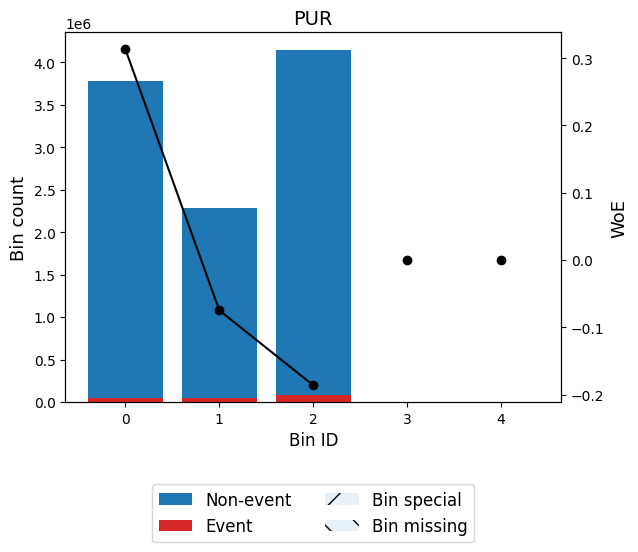


COLUMN: PRO
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[Co_operative, Condominium]",928008,0.090896,913308,14700,0.015840,0.107291,0.000994,0.000124
1,[Single_Family],6383439,0.625242,6270562,112877,0.017683,-0.004613,0.000013,0.000002
2,"[Planned_Urban, Manufact_Home]",2898096,0.283861,2845956,52140,0.017991,-0.022213,0.000142,0.000018
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10209543,1.000000,10029826,179717,0.017603,,0.001149,0.000144


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.01242845
    IV (Jeffrey)             0.00114884
    JS (Jensen-Shannon)      0.00014355
    Hellinger                0.00014358
    Triangular               0.00057394
    KS                       0.00926394
    HHI                      0.47976749
    HHI (normalized)         0.34970936
    Cramer's V               0.00436270
    Quality score            0.00310939

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic      p-value     P[A > B]  P[B > A]
        0      1   160.416976 9.173708e-37 2.112156e-39  1.000000
        1      2    10.851082 9.873803e-04 2.655636e-04  0.999734

None


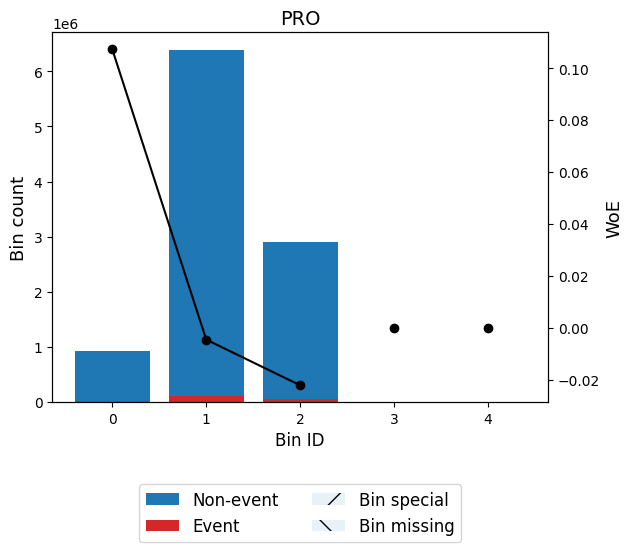


COLUMN: OCC
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[Second, Investor]",932916,0.091377,921768,11148,0.011950,0.393098,0.011743,0.001458
1,[Principal],9276627,0.908623,9108058,168569,0.018171,-0.032366,0.000967,0.000121
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10209543,1.000000,10029826,179717,0.017603,,0.012709,0.001579


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.02987183
    IV (Jeffrey)             0.01270938
    JS (Jensen-Shannon)      0.00157929
    Hellinger                0.00158396
    Triangular               0.00628019
    KS                       0.02987183
    HHI                      0.83394574
    HHI (normalized)         0.77859432
    Cramer's V               0.01363285
    Quality score            0.01171731

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic  p-value  P[A > B]  P[B > A]
        0      1  1897.491874      0.0       0.0       1.0

None


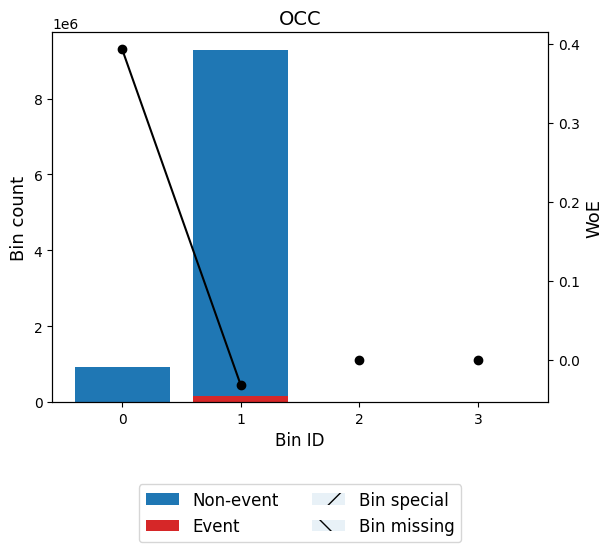


COLUMN: MI
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[Borrower, Lender, Investor]",10209543,1.0,10029826,179717,0.017603,0.0,0.0,0.0
1,Special,0,0.0,0,0,0.000000,0.0,0.0,0.0
2,Missing,0,0.0,0,0,0.000000,0.0,0.0,0.0
Totals,,10209543,1.0,10029826,179717,0.017603,,0.0,0.0


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.00000000
    IV (Jeffrey)             0.00000000
    JS (Jensen-Shannon)      0.00000000
    Hellinger                0.00000000
    Triangular               0.00000000
    KS                       0.00000000
    HHI                      1.00000000
    HHI (normalized)         1.00000000
    Cramer's V               0.00000000
    Quality score            0.00000000

  Monotonic trend             undefined

  Significance tests

    None

None


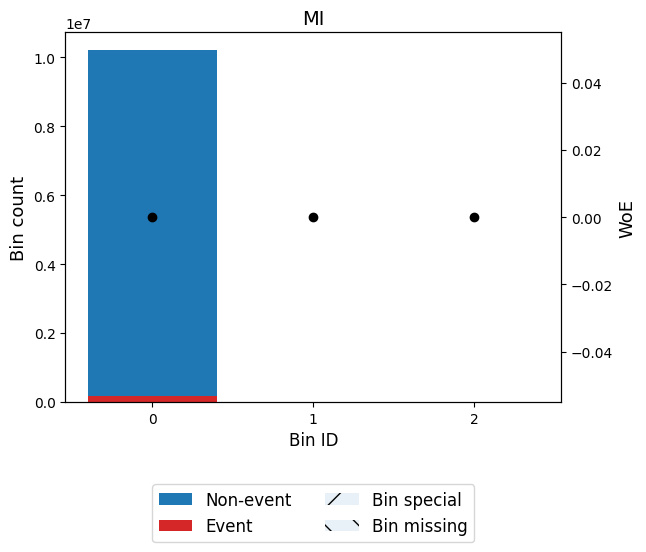


COLUMN: FTHB_FLAG
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[0],8201692,0.803336,8071222,130470,0.015908,0.102982,0.008110,0.001013
1,[1],2007851,0.196664,1958604,49247,0.024527,-0.338796,0.026679,0.003319
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10209543,1.000000,10029826,179717,0.017603,,0.034789,0.004332


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.07874731
    IV (Jeffrey)             0.03478883
    JS (Jensen-Shannon)      0.00433230
    Hellinger                0.00434043
    Triangular               0.01726469
    KS                       0.07874731
    HHI                      0.68402529
    HHI (normalized)         0.57870038
    Cramer's V               0.02605311
    Quality score            0.06082630

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic  p-value  P[A > B]  P[B > A]
        0      1  6929.874495      0.0       0.0       1.0

None


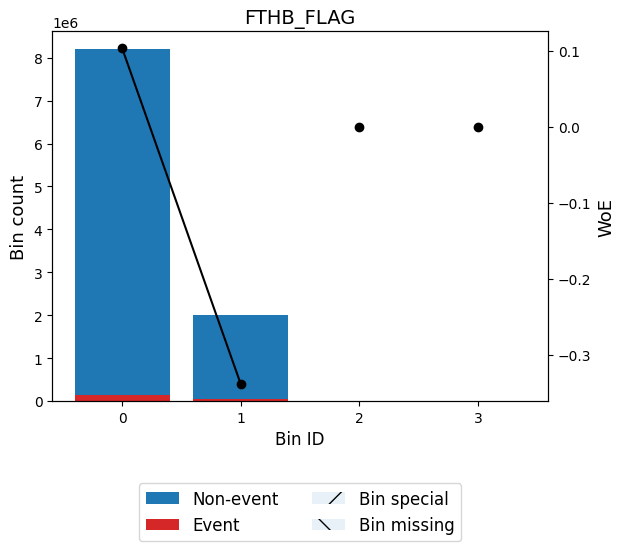

In [10]:
iv_per_col = {}
opt_bin_data = processed_df.copy()

for col in CAT_COLUMNS:
    print("====================================================================================================")
    print("COLUMN:", col)
    print("====================================================================================================")
    optb = OptimalBinning(name=col, dtype="categorical", solver="cp")
    optb.fit(processed_df[col], processed_df["DLQ_90_FLAG"])
    print(optb.status)
    display(optb.binning_table.build())
    print(optb.binning_table.analysis())
    iv_per_col[col] = optb.binning_table.iv
    optb.binning_table.plot(metric="woe")
    opt_bin_data[col] = optb.transform(opt_bin_data[col], metric="woe")
    print()


## Numerical variables

In [12]:
NUMERICAL_COLUMNS = [
    "ORIG_RATE",
    "ORIG_AMOUNT",	
    "ORIG_TERM",
    "OLTV",
    "NUM_BO", 
    "DTI",
    "CSCORE_B", 
    "CSCORE_C",
    "NUM_UNIT",
    "MI_PCT"]

In [19]:
help(OptimalBinning)

Help on class OptimalBinning in module optbinning.binning.binning:

class OptimalBinning(optbinning.binning.base.BaseOptimalBinning)
 |  OptimalBinning(name='', dtype='numerical', prebinning_method='cart', solver='cp', divergence='iv', max_n_prebins=20, min_prebin_size=0.05, min_n_bins=None, max_n_bins=None, min_bin_size=None, max_bin_size=None, min_bin_n_nonevent=None, max_bin_n_nonevent=None, min_bin_n_event=None, max_bin_n_event=None, monotonic_trend='auto', min_event_rate_diff=0, max_pvalue=None, max_pvalue_policy='consecutive', gamma=0, outlier_detector=None, outlier_params=None, class_weight=None, cat_cutoff=None, cat_unknown=None, user_splits=None, user_splits_fixed=None, special_codes=None, split_digits=None, mip_solver='bop', time_limit=100, verbose=False, **prebinning_kwargs)
 |
 |  Optimal binning of a numerical or categorical variable with respect to a
 |  binary target.
 |
 |  Parameters
 |  ----------
 |  name : str, optional (default="")
 |      The variable name.
 |
 | 

COLUMN: ORIG_RATE
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 2.59)",1189582,0.116517,1183836,5746,0.004830,1.306076,0.112400,0.013129
1,"[2.59, 2.69)",531496,0.052059,527704,3792,0.007135,0.913707,0.028794,0.003479
2,"[2.69, 2.81)",881843,0.086374,874300,7543,0.008554,0.730868,0.033034,0.004040
3,"[2.81, 2.99)",1135095,0.111180,1122915,12180,0.010730,0.501953,0.022178,0.002744
4,"[2.99, 3.10)",1060614,0.103885,1045658,14956,0.014101,0.225354,0.004740,0.000591
5,"[3.10, 3.23)",653367,0.063996,643221,10146,0.015529,0.127474,0.000978,0.000122
6,"[3.23, 3.34)",794012,0.077772,778776,15236,0.019189,-0.087873,0.000627,0.000078
7,"[3.34, inf)",3963534,0.388219,3853416,110118,0.027783,-0.466772,0.106674,0.013214
8,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
9,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.28562788
    IV (Jeffrey)             0.30942546
    JS (Jensen-Shannon)      0.03739809
    Hellinger                0.03801728
    Triangular               0.14507775
    KS                       0.23566604
    HHI                      0.20775725
    HHI (normalized)         0.11973027
    Cramer's V               0.06759514
    Quality score            0.83590312

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic       p-value      P[A > B]  P[B > A]
        0      1   353.942381  5.870076e-79 6.199795e-176       1.0
        1      2    83.944397  5.088878e-20  3.297679e-24       1.0
        2      3   242.837880  9.460976e-55  9.908557e-78       1.0
        3      4   510.425925 5.123251e-113 2.911573e-190       1.0
        4      5    57.092834  4.15717

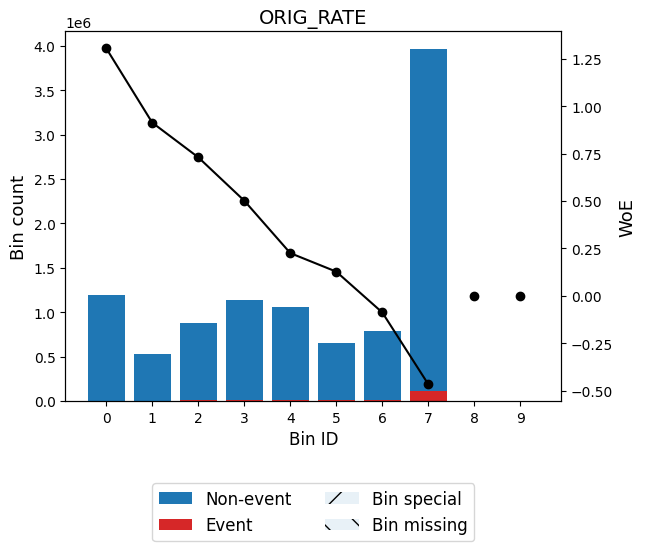


COLUMN: ORIG_AMOUNT
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 151500.00)",1887043,0.184831,1856727,30316,0.016065,0.09296,0.001528,1.908837e-04
1,"[151500.00, 205500.00)",1651368,0.161747,1624253,27115,0.016420,0.070781,0.000783,9.788918e-05
2,"[205500.00, 250500.00)",1357368,0.132951,1334962,22406,0.016507,0.065394,0.000551,6.885946e-05
3,"[250500.00, 321500.00)",1789948,0.175321,1759588,30360,0.016961,0.037774,0.000246,3.070494e-05
4,"[321500.00, 350500.00)",602147,0.058979,591440,10707,0.017781,-0.010273,0.000006,7.818466e-07
5,"[350500.00, 402500.00)",870613,0.085274,853844,16769,0.019261,-0.091719,0.000750,9.371869e-05
6,"[402500.00, inf)",2051056,0.200896,2009012,42044,0.020499,-0.155253,0.005223,6.522213e-04
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00
Totals,,10209543,1.000000,10029826,179717,0.017603,,0.009087,1.135059e-03


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.05047469
    IV (Jeffrey)             0.00908680
    JS (Jensen-Shannon)      0.00113506
    Hellinger                0.00113545
    Triangular               0.00453708
    KS                       0.04242802
    HHI                      0.15984770
    HHI (normalized)         0.05482866
    Cramer's V               0.01276146
    Quality score            0.01578787

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic      p-value     P[A > B]  P[B > A]
        0      1     6.926404 8.493231e-03 3.895980e-03  0.996104
        1      2     0.350147 5.540299e-01 2.771035e-01  0.722897
        2      3     9.671221 1.871769e-03 8.075840e-04  0.999192
        3      4    17.954908 2.262004e-05 4.039463e-07  1.000000
        4      5    42.573640 6.807058e-11 1.268

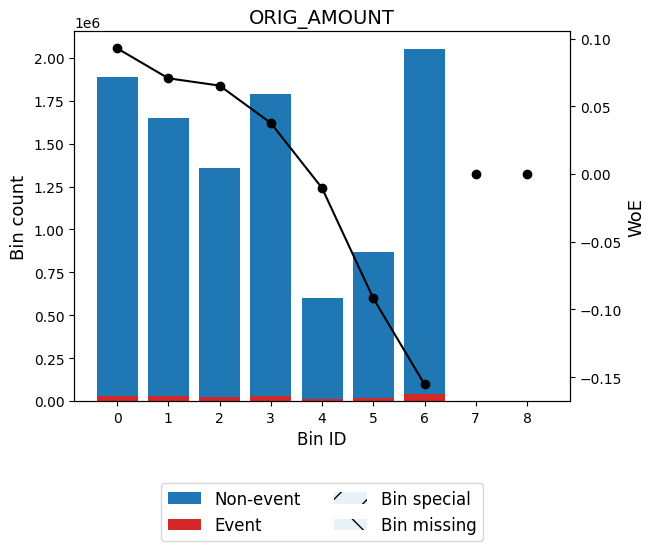


COLUMN: ORIG_TERM
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 228.50)",1766301,0.173005,1752915,13386,0.007579,0.852891,0.085533,0.010379
1,"[228.50, 322.50)",665065,0.065142,658435,6630,0.009969,0.576326,0.016573,0.002043
2,"[322.50, inf)",7778177,0.761854,7618476,159701,0.020532,-0.156907,0.020248,0.002528
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10209543,1.000000,10029826,179717,0.017603,,0.122354,0.014951


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.13060064
    IV (Jeffrey)             0.12235414
    JS (Jensen-Shannon)      0.01495076
    Hellinger                0.01511962
    Triangular               0.05851755
    KS                       0.12904282
    HHI                      0.61459501
    HHI (normalized)         0.51824376
    Cramer's V               0.04003501
    Quality score            0.23411387

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic      p-value      P[A > B]  P[B > A]
        0      1   338.129453 1.630218e-75 7.240074e-192       1.0
        1      2  3539.832409 0.000000e+00  0.000000e+00       1.0

None


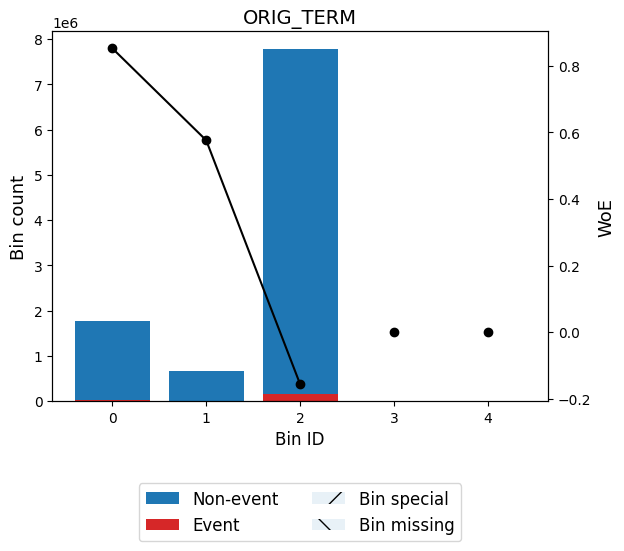


COLUMN: OLTV
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 35.50)",553360,0.054200,550481,2879,0.005203,1.231414,0.047859,5.630869e-03
1,"[35.50, 44.50)",574907,0.056311,571151,3756,0.006533,1.002364,0.036131,4.336310e-03
2,"[44.50, 54.50)",1000330,0.097980,992038,8292,0.008289,0.762535,0.040239,4.911409e-03
3,"[54.50, 59.50)",699352,0.068500,692130,7222,0.010327,0.540707,0.015584,1.924627e-03
4,"[59.50, 64.50)",758756,0.074318,749023,9733,0.012828,0.321312,0.006594,8.207267e-04
5,"[64.50, 68.50)",564427,0.055284,556259,8168,0.014471,0.199075,0.001993,2.487129e-04
6,"[68.50, 76.50)",1772214,0.173584,1741158,31056,0.017524,0.004579,0.000004,4.538485e-07
7,"[76.50, 80.50)",1859097,0.182094,1824418,34679,0.018654,-0.059053,0.000653,8.166769e-05
8,"[80.50, 92.50)",1015270,0.099443,989897,25373,0.024991,-0.35802,0.015211,1.891342e-03
9,"[92.50, inf)",1411830,0.138285,1363271,48559,0.034394,-0.687072,0.092257,1.131050e-02


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.27370256
    IV (Jeffrey)             0.25652479
    JS (Jensen-Shannon)      0.03115662
    Hellinger                0.03160032
    Triangular               0.12131112
    KS                       0.18782831
    HHI                      0.12128188
    HHI (normalized)         0.04139841
    Cramer's V               0.06551163
    Quality score            0.83035515

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic       p-value     P[A > B]  P[B > A]
        0      1    85.375966  2.467011e-20 3.470220e-27       1.0
        1      2   148.329032  4.019822e-34 4.393849e-43       1.0
        2      3   188.914959  5.484986e-43 6.042832e-74       1.0
        3      4   198.044654  5.578821e-45 5.458602e-66       1.0
        4      5    65.525936  5.735418e-16

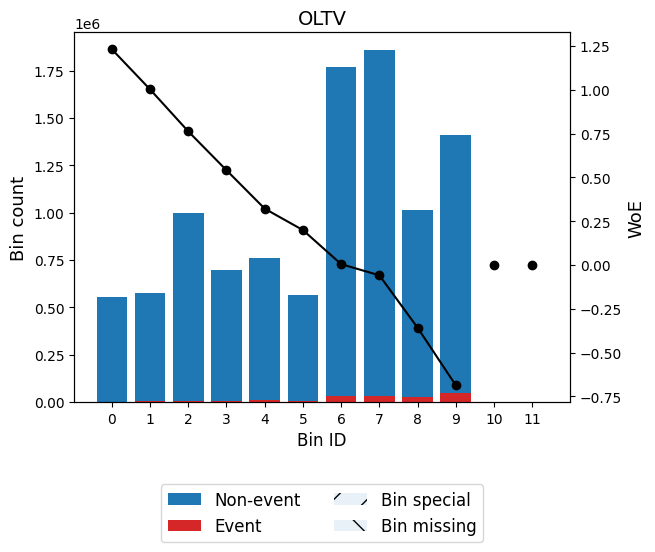


COLUMN: NUM_BO
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",5437608,0.532601,5313477,124131,0.022828,-0.265271,0.042691,0.005321
1,"[1.50, inf)",4771935,0.467399,4716349,55586,0.011649,0.418924,0.067419,0.008366
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10209543,1.000000,10029826,179717,0.017603,,0.110111,0.013687


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.16093499
    IV (Jeffrey)             0.11011086
    JS (Jensen-Shannon)      0.01368718
    Hellinger                0.01372537
    Triangular               0.05444664
    KS                       0.16093499
    HHI                      0.50212559
    HHI (normalized)         0.33616745
    Cramer's V               0.04241706
    Quality score            0.29296526

  Monotonic trend            descending

  Significance tests

    Bin A  Bin B  t-statistic  p-value  P[A > B]  P[B > A]
        0      1 18369.079713      0.0       1.0       0.0

None


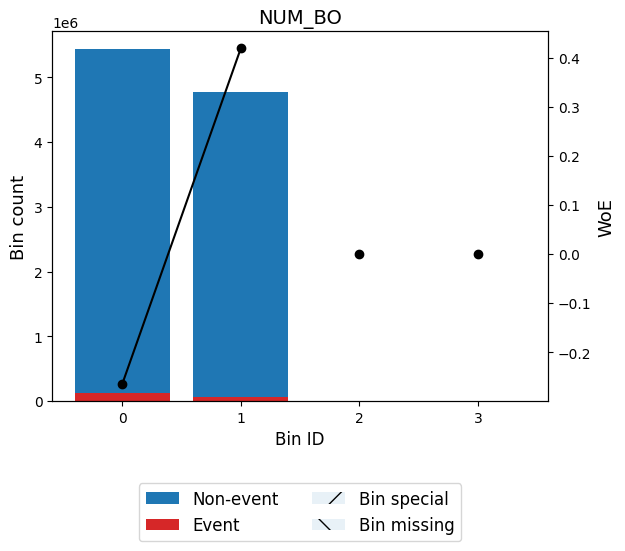


COLUMN: DTI
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 17.50)",594678,0.058247,592039,2639,0.004438,1.391237,0.061693,0.007144
1,"[17.50, 22.50)",882065,0.086396,876581,5484,0.006217,1.052259,0.059855,0.007155
2,"[22.50, 25.50)",717342,0.070262,711370,5972,0.008325,0.758176,0.028580,0.003489
3,"[25.50, 27.50)",538428,0.052738,532981,5447,0.010116,0.561486,0.012819,0.001582
4,"[27.50, 31.50)",1188616,0.116422,1173665,14951,0.012578,0.341173,0.011540,0.001436
5,"[31.50, 33.50)",632010,0.061904,622578,9432,0.014924,0.167826,0.001609,0.000201
6,"[33.50, 37.50)",1332743,0.130539,1308990,23753,0.017823,-0.012633,0.000021,0.000003
7,"[37.50, 39.50)",699207,0.068486,684527,14680,0.020995,-0.179693,0.002414,0.000301
8,"[39.50, 41.50)",723463,0.070861,705924,17539,0.024243,-0.326855,0.008894,0.001107
9,"[41.50, inf)",2900991,0.284145,2821171,79820,0.027515,-0.456802,0.074397,0.009220


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.26588884
    IV (Jeffrey)             0.26182240
    JS (Jensen-Shannon)      0.03163688
    Hellinger                0.03216413
    Triangular               0.12271083
    KS                       0.20516843
    HHI                      0.14345167
    HHI (normalized)         0.06558364
    Cramer's V               0.06155195
    Quality score            0.81890995

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic      p-value      P[A > B]  P[B > A]
        0      1   205.623941 1.237784e-46  9.433216e-63       1.0
        1      2   247.192948 1.062713e-55  4.953515e-92       1.0
        2      3   109.530244 1.241951e-25  1.412784e-39       1.0
        3      4   192.451049 9.275504e-44  7.283082e-54       1.0
        4      5   171.766391 3.043550e-39 

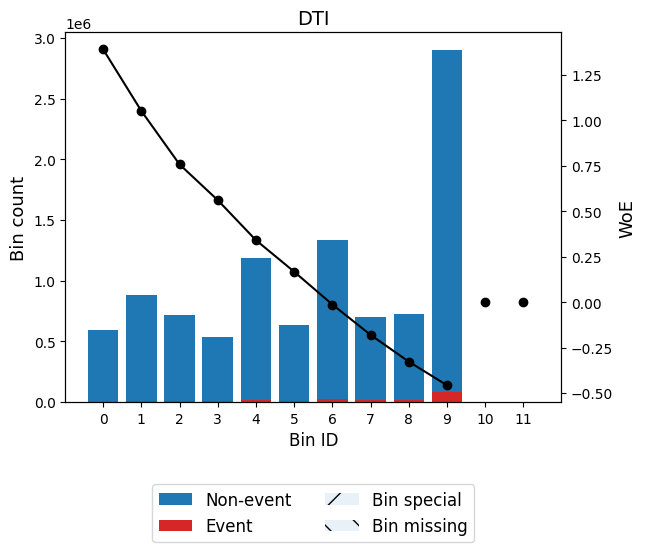


COLUMN: CSCORE_B
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 677.50)",517741,0.050711,480861,36880,0.071233,-1.454026,0.228672,2.630537e-02
1,"[677.50, 702.50)",675423,0.066156,644550,30873,0.045709,-0.983265,0.105724,1.270760e-02
2,"[702.50, 724.50)",882993,0.086487,853318,29675,0.033607,-0.663108,0.053077,6.515671e-03
3,"[724.50, 744.50)",1023605,0.100260,999231,24374,0.023812,-0.308466,0.011104,1.382558e-03
4,"[744.50, 753.50)",575227,0.056342,564994,10233,0.017789,-0.010738,0.000007,8.162525e-07
5,"[753.50, 769.50)",1232657,0.120736,1216319,16338,0.013254,0.288156,0.008749,1.089804e-03
6,"[769.50, 783.50)",1367966,0.133989,1355450,12516,0.009149,0.662946,0.043422,5.330532e-03
7,"[783.50, 796.50)",1518839,0.148767,1509491,9348,0.006155,1.06243,0.104634,1.249681e-02
8,"[796.50, 803.50)",939959,0.092067,935553,4406,0.004687,1.336235,0.091881,1.070029e-02
9,"[803.50, inf)",1475133,0.144486,1470059,5074,0.003440,1.646993,0.194898,2.193524e-02


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.49360888
    IV (Jeffrey)             0.84216692
    JS (Jensen-Shannon)      0.09846469
    Hellinger                0.10170371
    Triangular               0.37123324
    KS                       0.38144104
    HHI                      0.11166877
    HHI (normalized)         0.03091139
    Cramer's V               0.13167489
    Quality score            0.35325890

  Monotonic trend            descending

  Significance tests

    Bin A  Bin B  t-statistic       p-value  P[A > B]  P[B > A]
        0      1  3564.722368  0.000000e+00       1.0       0.0
        1      2  1500.881360  0.000000e+00       1.0       0.0
        2      3  1651.326557  0.000000e+00       1.0       0.0
        3      4   630.744576 3.442573e-139       1.0       0.0
        4      5   557.054215 3.676456e-123       1.0     

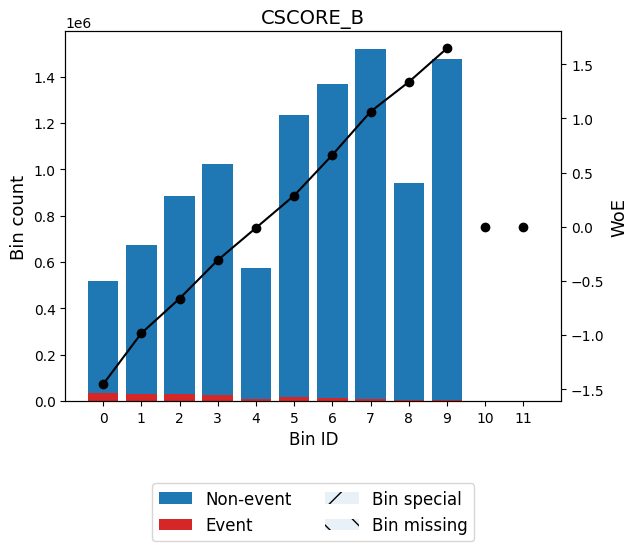


COLUMN: CSCORE_C
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 678.50)",520577,0.050989,485166,35411,0.068023,-1.404467,0.208795,0.024146
1,"[678.50, 703.50)",688639,0.067451,657649,30990,0.045002,-0.966928,0.103334,0.012436
2,"[703.50, 724.50)",837048,0.081987,809296,27752,0.033155,-0.649078,0.047858,0.005879
3,"[724.50, 744.50)",1027633,0.100654,1003072,24561,0.023901,-0.312272,0.011447,0.001425
4,"[744.50, 753.50)",576913,0.056507,566556,10357,0.017952,-0.020022,0.000023,0.000003
5,"[753.50, 765.50)",900779,0.088229,887904,12875,0.014293,0.211641,0.003574,0.000446
6,"[765.50, 780.50)",1370690,0.134256,1356531,14159,0.010330,0.5404,0.030514,0.003768
7,"[780.50, 795.50)",1671880,0.163757,1659963,11917,0.007128,0.914649,0.090727,0.010961
8,"[795.50, 806.50)",1399109,0.137039,1392025,7084,0.005063,1.258741,0.125082,0.014679
9,"[806.50, inf)",1216275,0.119131,1211664,4611,0.003791,1.54937,0.147421,0.016781


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.47489222
    IV (Jeffrey)             0.76877412
    JS (Jensen-Shannon)      0.09052399
    Hellinger                0.09319093
    Triangular               0.34320098
    KS                       0.36706364
    HHI                      0.11279287
    HHI (normalized)         0.03213768
    Cramer's V               0.12596627
    Quality score            0.46976232

  Monotonic trend            descending

  Significance tests

    Bin A  Bin B  t-statistic       p-value  P[A > B]  P[B > A]
        0      1  3027.403953  0.000000e+00       1.0       0.0
        1      2  1432.439043  0.000000e+00       1.0       0.0
        2      3  1448.775205  0.000000e+00       1.0       0.0
        3      4   614.062086 1.462991e-135       1.0       0.0
        4      5   304.306580  3.797822e-68       1.0     

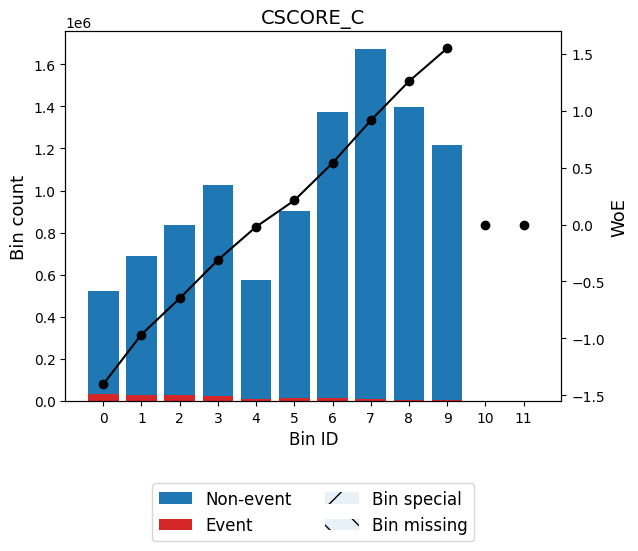


COLUMN: NUM_UNIT
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",10209543,1.0,10029826,179717,0.017603,0.0,0.0,0.0
1,Special,0,0.0,0,0,0.000000,0.0,0.0,0.0
2,Missing,0,0.0,0,0,0.000000,0.0,0.0,0.0
Totals,,10209543,1.0,10029826,179717,0.017603,,0.0,0.0


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.00000000
    IV (Jeffrey)             0.00000000
    JS (Jensen-Shannon)      0.00000000
    Hellinger                0.00000000
    Triangular               0.00000000
    KS                       0.00000000
    HHI                      1.00000000
    HHI (normalized)         1.00000000
    Cramer's V               0.00000000
    Quality score            0.00000000

  Monotonic trend             undefined

  Significance tests

    None

None


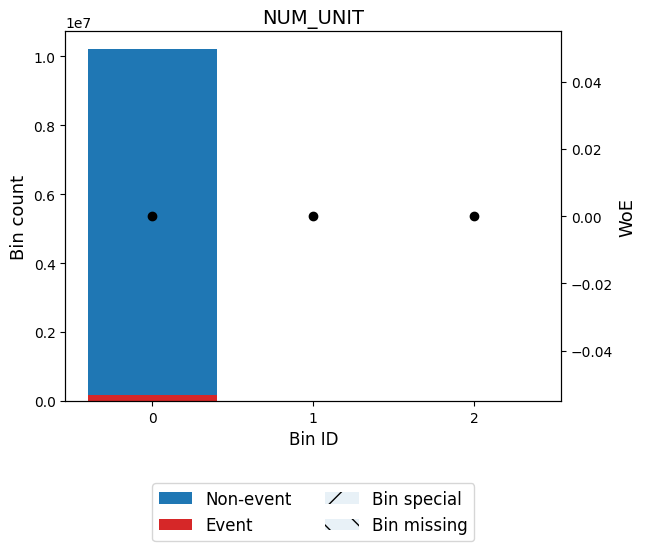


COLUMN: MI_PCT
OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 11.50)",7814851,0.765446,7708199,106652,0.013647,0.258534,0.045265,0.005642
1,"[11.50, 27.50)",1234360,0.120903,1199158,35202,0.028518,-0.493663,0.037674,0.004662
2,"[27.50, inf)",1160332,0.113652,1122469,37863,0.032631,-0.632624,0.062483,0.007683
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10209543,1.000000,10029826,179717,0.017603,,0.145422,0.017987


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.17835149
    IV (Jeffrey)             0.14542212
    JS (Jensen-Shannon)      0.01798712
    Hellinger                0.01808166
    Triangular               0.07121052
    KS                       0.17508355
    HHI                      0.61344129
    HHI (normalized)         0.51680162
    Cramer's V               0.05486246
    Quality score            0.27363536

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic      p-value      P[A > B]  P[B > A]
        0      1 15278.033007 0.000000e+00  0.000000e+00       1.0
        1      2   342.009142 2.329801e-76 3.740342e-126       1.0

None


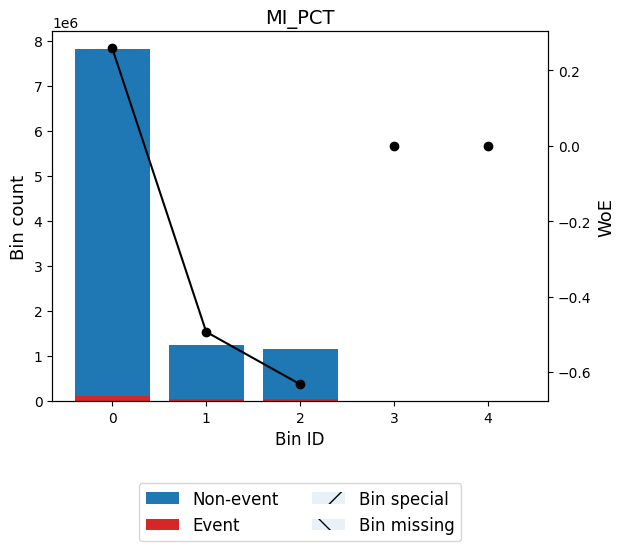

In [13]:

for col in NUMERICAL_COLUMNS:
    print("====================================================================================================")
    print("COLUMN:", col)
    print("====================================================================================================")
    optb = OptimalBinning(name=col, dtype="numerical", solver="cp", monotonic_trend="auto_asc_desc", max_n_bins=10)
    optb.fit(processed_df[col], processed_df["DLQ_90_FLAG"])
    print(optb.status)
    display(optb.binning_table.build())
    print(optb.binning_table.analysis())
    iv_per_col[col] = optb.binning_table.iv
    optb.binning_table.plot(metric="woe")
    opt_bin_data[col] = optb.transform(processed_df[col], metric="woe")
    print()

In [14]:
opt_bin_data

,ORIG_RATE,ORIG_AMOUNT,ORIG_TERM,OLTV,NUM_BO,DTI,CSCORE_B,CSCORE_C,FTHB_FLAG,NUM_UNIT,MI_PCT,DLQ_90_FLAG,PUR,PRO,MI,OCC
0,-0.466772,0.065394,-0.156907,0.321312,-0.265271,-0.012633,1.336235,1.258741,0.102982,0.0,0.258534,0,-0.186269,-0.022213,0.0,0.393098
1,-0.466772,0.070781,-0.156907,0.762535,-0.265271,-0.326855,-0.010738,-0.020022,0.102982,0.0,0.258534,0,-0.074944,-0.004613,0.0,-0.032366
2,-0.466772,0.065394,-0.156907,0.004579,0.418924,0.561486,1.336235,1.258741,0.102982,0.0,0.258534,0,-0.186269,-0.022213,0.0,0.393098
3,-0.466772,-0.091719,-0.156907,-0.358020,-0.265271,-0.456802,1.062430,0.914649,-0.338796,0.0,-0.493663,0,-0.186269,-0.004613,0.0,-0.032366
4,-0.466772,-0.010273,-0.156907,0.762535,0.418924,-0.012633,-1.454026,-1.404467,0.102982,0.0,0.258534,1,-0.186269,-0.004613,0.0,-0.032366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4782086,-0.466772,0.070781,-0.156907,0.004579,0.418924,0.341173,-0.010738,-0.312272,0.102982,0.0,0.258534,0,-0.074944,-0.004613,0.0,0.393098
4782088,0.225354,-0.155253,-0.156907,-0.358020,-0.265271,-0.012633,-0.308466,-0.312272,-0.338796,0.0,-0.493663,0,-0.186269,0.107291,0.0,-0.032366
4782089,1.306076,0.070781,0.852891,0.004579,0.418924,0.341173,0.662946,-0.649078,0.102982,0.0,0.258534,0,-0.074944,-0.004613,0.0,-0.032366
4782090,1.306076,0.065394,0.852891,0.762535,0.418924,-0.326855,0.288156,-0.649078,0.102982,0.0,0.258534,0,-0.074944,-0.022213,0.0,-0.032366


# Model fitting

In [15]:
iv_per_col

{'PUR': 0.04810957237835907,
 'PRO': 0.0011488418463485412,
 'OCC': 0.012709383550650015,
 'MI': 0.0,
 'FTHB_FLAG': 0.03478883330132603,
 'ORIG_RATE': 0.3094254586748635,
 'ORIG_AMOUNT': 0.009086801137728886,
 'ORIG_TERM': 0.12235414164502238,
 'OLTV': 0.2565247924937545,
 'NUM_BO': 0.11011085862864958,
 'DTI': 0.26182239717120925,
 'CSCORE_B': 0.842166915137274,
 'CSCORE_C': 0.7687741199613817,
 'NUM_UNIT': 0.0,
 'MI_PCT': 0.14542211619467652}

# 2 factor model
If we only accept predictors with an IV of > 0.3, we select ORIG_RATE and CSCORE_B

In [16]:
X_2factor, Y_2factor = opt_bin_data[["ORIG_RATE","CSCORE_B"]], opt_bin_data["DLQ_90_FLAG"]
train_split = 0.7
X_2f_train, X_2f_test = X_2factor[:int(train_split*len(X_2factor))], X_2factor[int(train_split*len(X_2factor)):]
Y_2f_train, Y_2f_test = Y_2factor[:int(train_split*len(X_2factor))], Y_2factor[int(train_split*len(X_2factor)):]

In [17]:
def fit_logistic_regression(
    train: list[pd.DataFrame, pd.DataFrame],
    test: list[pd.DataFrame, pd.DataFrame],
    model_config: dict = {}
):
    logistic_model = linear_model.LogisticRegression(
        C = model_config.get("C", 1),
        solver=model_config.get("solver", "liblinear"),
        random_state=model_config.get("random_state", 0),
        class_weight=model_config.get("class_weight", None)
    )
    logistic_model.fit(train[0], train[1])

    print("Training accuracy:", logistic_model.score(train[0], train[1]))
    print("Testing accuracy:", logistic_model.score(test[0], test[1]))
    print(
        classification_report(
            y_pred=logistic_model.predict(test[0]),
            y_true=test[1]
        )
    )
    # Training AUC
    fpr, tpr, thresholds = metrics.roc_curve(train[1], logistic_model.predict(train[0]), pos_label=1)
    print("Training AUC:", metrics.auc(fpr, tpr))

    # Testing AUC
    fpr, tpr, thresholds = metrics.roc_curve(test[1], logistic_model.predict(test[0]), pos_label=1)
    print("Testing AUC:", metrics.auc(fpr, tpr))
    return logistic_model

In [18]:
woe_model = fit_logistic_regression(
    [X_2f_train, Y_2f_train],
    [X_2f_test, Y_2f_test]
)

Training accuracy: 0.9808603435441352
Testing accuracy: 0.9859830491928631


/Users/melina/Documents/Uni/Fall 2024/MIE479/msf-capstone-crm/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/melina/Documents/Uni/Fall 2024/MIE479/msf-capstone-crm/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/melina/Documents/Uni/Fall 2024/MIE479/msf-capstone-crm/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

              precision    recall  f1-score   support

           0       0.99      1.00      0.99   3019931
           1       0.00      0.00      0.00     42932

    accuracy                           0.99   3062863
   macro avg       0.49      0.50      0.50   3062863
weighted avg       0.97      0.99      0.98   3062863

Training AUC: 0.5
Testing AUC: 0.5


In [19]:
# Weight Balanced
woe_2f_model = fit_logistic_regression(
    [X_2f_train, Y_2f_train],
    [X_2f_test, Y_2f_test],
    model_config={
        "class_weight": {
            0 :  len(Y_2f_train)/(2*(len(Y_2f_train)-sum(Y_2f_train))),
            1 :  len(Y_2f_train)/(2* sum(Y_2f_train))
        }
    }
)

Training accuracy: 0.6455771071322628
Testing accuracy: 0.7030324242383679
              precision    recall  f1-score   support

           0       0.99      0.70      0.82   3019931
           1       0.03      0.74      0.06     42932

    accuracy                           0.70   3062863
   macro avg       0.51      0.72      0.44   3062863
weighted avg       0.98      0.70      0.81   3062863

Training AUC: 0.689702906358052
Testing AUC: 0.7193742721213934


In [20]:
oversample = SMOTE()
X_2f_train_smote, Y_2f_train_smote = oversample.fit_resample(X_2f_train, Y_2f_train)
complete_model = fit_logistic_regression(
    [X_2f_train_smote, Y_2f_train_smote],
    [X_2f_test, Y_2f_test],
    # model_config={"C" : 100,}
)

Training accuracy: 0.6895120397666441
Testing accuracy: 0.7030324242383679
              precision    recall  f1-score   support

           0       0.99      0.70      0.82   3019931
           1       0.03      0.74      0.06     42932

    accuracy                           0.70   3062863
   macro avg       0.51      0.72      0.44   3062863
weighted avg       0.98      0.70      0.81   3062863

Training AUC: 0.6895120397666441
Testing AUC: 0.7193742721213934


# Including OLTV and DTI
considering factors with IV > 0.2.

In [21]:
X_4factor, Y_4factor = opt_bin_data[["ORIG_RATE","CSCORE_B", "OLTV", "DTI"]], opt_bin_data["DLQ_90_FLAG"]
train_split = 0.7
X_4f_train, X_4f_test = X_2factor[:int(train_split*len(X_4factor))], X_2factor[int(train_split*len(X_4factor)):]
Y_4f_train, Y_4f_test = Y_2factor[:int(train_split*len(X_4factor))], Y_2factor[int(train_split*len(X_4factor)):]

In [22]:
# Weight Balanced
woe_4f_model = fit_logistic_regression(
    [X_4f_train, Y_4f_train],
    [X_4f_test, Y_4f_test],
    model_config={
        "class_weight": {
            0 :  len(Y_4f_train)/(2*(len(Y_4f_train)-sum(Y_4f_train))),
            1 :  len(Y_4f_train)/(2* sum(Y_4f_train))
        }
    }
)

Training accuracy: 0.6455771071322628
Testing accuracy: 0.7030324242383679
              precision    recall  f1-score   support

           0       0.99      0.70      0.82   3019931
           1       0.03      0.74      0.06     42932

    accuracy                           0.70   3062863
   macro avg       0.51      0.72      0.44   3062863
weighted avg       0.98      0.70      0.81   3062863

Training AUC: 0.689702906358052
Testing AUC: 0.7193742721213934


# Testing WOE generated on SVM, and XGBoost

In [24]:
# XGBoost
weight_deliquent =  len(Y_4f_train)/(2* sum(Y_4f_train))
scaler_weight_xgb = XGBClassifier(scale_pos_weight=weight_deliquent, eval_metric='auc')
scaler_weight_xgb.fit(X_4f_train, Y_4f_train)
y_pred = scaler_weight_xgb.predict(X_4f_test)
accuracy = accuracy_score(Y_4f_test, y_pred)
roc_auc = roc_auc_score(Y_4f_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"AUC-ROC: {roc_auc}")
print("Classification Report")
print(classification_report(Y_4f_test, y_pred))

Accuracy: 0.8624920540030684
AUC-ROC: 0.6741329006681497
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.87      0.93   3019931
           1       0.05      0.48      0.09     42932

    accuracy                           0.86   3062863
   macro avg       0.52      0.67      0.51   3062863
weighted avg       0.98      0.86      0.91   3062863



In [27]:
# SVM
svm_model = LinearSVC(random_state=99, max_iter=8192, class_weight='balanced')
svm_model.fit(X_4f_train, Y_4f_train)

y_pred = svm_model.predict(X_4f_test)
accuracy = accuracy_score(Y_4f_test, y_pred)
roc_auc = roc_auc_score(Y_4f_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"AUC-ROC: {roc_auc}")
print("Classification Report")
print(classification_report(Y_4f_test, y_pred))

Accuracy: 0.7030324242383679
AUC-ROC: 0.7193742721213934
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.70      0.82   3019931
           1       0.03      0.74      0.06     42932

    accuracy                           0.70   3062863
   macro avg       0.51      0.72      0.44   3062863
weighted avg       0.98      0.70      0.81   3062863

